## Project 3: Web API's and NLP

### Model and Predictions

In [58]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier 
from sklearn.metrics import balanced_accuracy_score, f1_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [8]:
# read the csv file
df = pd.read_csv('data/clean_combined.csv')

#### Null Model / Baseline

In [10]:
# value composition in the target column
df['subreddit'].value_counts(normalize = True)

poker    0.519231
chess    0.480769
Name: subreddit, dtype: float64

#### Train Test Split

In [12]:
# define X and y
X = df['title']
y = df['subreddit']

In [13]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

#### 1. Naive Bayes

In [20]:
# instantiate a pipe
pipe_nb = make_pipeline(CountVectorizer(stop_words = 'english', ngram_range = (2,2)), StandardScaler MultinomialNB())

In [21]:
# fit the data
pipe_nb.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(ngram_range=(2, 2), stop_words='english')),
                ('multinomialnb', MultinomialNB())])

In [34]:
# score on the train data
pipe_nb.score(X_train, y_train)

0.9774358974358974

In [35]:
# score on the test data
pipe_nb.score(X_test, y_test)

0.8257692307692308

#### 2. Naive Bayes with lemmatizing

In [15]:
# define a function that return a lowercase lemmatized list of words
def split_lemmatize(text):
    text_lower = text.lower()
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(x) for x in text_lower.split()])

In [16]:
# make a pipe with lemmatizer function
pipe_lem = make_pipeline(CountVectorizer(preprocessor = split_lemmatize, ngram_range = (2,2)), MultinomialNB())

In [17]:
# fit the data
pipe_lem.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(ngram_range=(2, 2),
                                 preprocessor=<function split_lemmatize at 0x0000022323BA54C0>)),
                ('multinomialnb', MultinomialNB())])

In [18]:
# score on the train data
pipe_lem.score(X_train, y_train)

0.9862820512820513

In [19]:
# score on the test data
pipe_lem.score(X_test, y_test)

0.8661538461538462

In [20]:
params_lem = {
            'countvectorizer__max_features': [100, 500, 1000, 10_000,],
            'countvectorizer__ngram_range': [(1,1), (2,2), (3,3)],
            'countvectorizer__stop_words': ['english', None],
            'multinomialnb__alpha': [0.01, 0.1, 1, 5, 10]
}

In [21]:
# start a gridsearch
grid_lem = GridSearchCV(pipe_lem, param_grid = params_lem, n_jobs = -1)

In [22]:
# fit the data
grid_lem.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(ngram_range=(2, 2),
                                                        preprocessor=<function split_lemmatize at 0x0000022323BA54C0>)),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [100, 500, 1000,
                                                           10000],
                         'countvectorizer__ngram_range': [(1, 1), (2, 2),
                                                          (3, 3)],
                         'countvectorizer__stop_words': ['english', None],
                         'multinomialnb__alpha': [0.01, 0.1, 1, 5, 10]})

In [23]:
# score on the train data
grid_lem.score(X_train, y_train)

0.9624358974358974

In [24]:
# accuracy score on the test data
grid_lem.score(X_test, y_test)

0.9253846153846154

In [56]:
# f1 score on the train data
f1_score(y_train, grid_lem.predict(X_train))

ValueError: pos_label=1 is not a valid label. It should be one of ['chess', 'poker']

In [60]:
recall_average = recall_score(y_test, grid_lem.predict(X_test), average="binary", pos_label="neg")

ValueError: pos_label=neg is not a valid label. It should be one of ['chess', 'poker']

In [25]:
# see what were the best parameters
grid_lem.best_params_

{'countvectorizer__max_features': 10000,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': None,
 'multinomialnb__alpha': 1}

In [26]:
# explore the dataframe of grid results
pd.DataFrame(grid_lem.cv_results_).sort_values(by = 'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__max_features,param_countvectorizer__ngram_range,param_countvectorizer__stop_words,param_multinomialnb__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
24,1.273324,0.088497,0.276885,0.021142,100,"(3, 3)",english,10,"{'countvectorizer__max_features': 100, 'countv...",0.542949,0.534615,0.544872,0.537821,0.542949,0.540641,0.003816,120
20,1.255444,0.146566,0.280761,0.028546,100,"(3, 3)",english,0.01,"{'countvectorizer__max_features': 100, 'countv...",0.542949,0.534615,0.544872,0.537821,0.543590,0.540769,0.003901,116
23,1.310724,0.101427,0.263945,0.023831,100,"(3, 3)",english,5,"{'countvectorizer__max_features': 100, 'countv...",0.542949,0.534615,0.544872,0.537821,0.543590,0.540769,0.003901,116
22,1.295691,0.044122,0.283155,0.016466,100,"(3, 3)",english,1,"{'countvectorizer__max_features': 100, 'countv...",0.542949,0.534615,0.544872,0.537821,0.543590,0.540769,0.003901,116
21,1.397148,0.146184,0.320671,0.030998,100,"(3, 3)",english,0.10,"{'countvectorizer__max_features': 100, 'countv...",0.542949,0.534615,0.544872,0.537821,0.543590,0.540769,0.003901,116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.350343,0.686224,1.370180,0.306367,10000,"(1, 1)",None,0.01,"{'countvectorizer__max_features': 10000, 'coun...",0.923077,0.930769,0.927564,0.925641,0.933333,0.928077,0.003635,5
91,3.635957,0.476644,0.804419,0.147536,10000,"(1, 1)",english,0.10,"{'countvectorizer__max_features': 10000, 'coun...",0.920513,0.933974,0.932051,0.926282,0.933974,0.929359,0.005245,4
92,3.327712,0.583729,0.841409,0.195023,10000,"(1, 1)",english,1,"{'countvectorizer__max_features': 10000, 'coun...",0.923077,0.933333,0.937179,0.926923,0.935256,0.931154,0.005311,3
96,4.357672,0.700420,1.039471,0.312508,10000,"(1, 1)",None,0.10,"{'countvectorizer__max_features': 10000, 'coun...",0.927564,0.935256,0.931410,0.932051,0.937821,0.932821,0.003497,2


In [27]:
# get feature names
features = grid_lem.best_estimator_.named_steps.countvectorizer.get_feature_names()

In [28]:
# coefficients
coefs = grid_lem.best_estimator_.named_steps['multinomialnb'].coef_

c:\users\anel akiyanova\anaconda3\envs\new\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [29]:
coefs_df = pd.DataFrame({'coefs': coefs[0], 'names': features}).sort_values(by = 'coefs', ascending = False).head(20)

In [30]:
coefs_df

,coefs,names
6493,-3.772199,the
4915,-3.812544,poker
6585,-3.989894,to
3362,-4.155538,in
2739,-4.371077,for
4551,-4.445768,on
707,-4.539854,and
7191,-4.641236,you
3503,-4.658759,is
4522,-4.713247,of


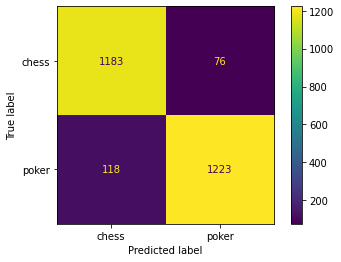

In [36]:
# plot confusion matrix 
plot_confusion_matrix(grid_lem, X_test, y_test);

#### 3. Logistic Regession

In [48]:
# instantiate a pipe
pipe_lr = make_pipeline(CountVectorizer(stop_words = 'english', ngram_range = (2,2)), StandardScaler(with_mean = False), LogisticRegression())

In [49]:
# fit the data
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(ngram_range=(2, 2), stop_words='english')),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('logisticregression', LogisticRegression())])

In [50]:
# score on the trian data
pipe_lr.score(X_train, y_train)

0.9793589743589743

In [51]:
# score on the test data
pipe_lr.score(X_test, y_test)

0.816923076923077

#### 4. Random Forest Classifier

In [42]:
# instantiate a pipe
pipe_forest = make_pipeline(CountVectorizer(stop_words = 'english', ngram_range = (2,2)), RandomForestClassifier())

In [43]:
# fit the data
pipe_forest.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(ngram_range=(2, 2), stop_words='english')),
                ('randomforestclassifier', RandomForestClassifier())])

In [44]:
# score on the train data
pipe_forest.score(X_train, y_train)

0.9793589743589743

In [45]:
# score on the test data
pipe_forest.score(X_test, y_test)

0.7753846153846153

#### 5. SVC

In [54]:
# make a pipe
pipe_svc = make_pipeline(CountVectorizer(ngram_range = (1,1)), StandardScaler(with_mean = False), SVC())

In [55]:
pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC())])

In [19]:
params_svc = {
        'countvectorizer__max_features': [50, 100, 500, 1000, 10_000], 
        'countvectorizer__ngram_range': [(1,1), (2,2), (3,3)],
        'countvectorizer__stop_words': ['english', None],
        'svc__gamma': ['scale', 'auto'],
        'svc__C': [0.01, 0.1, 1, 3, 5, 10]
}

In [20]:
grid_svc = GridSearchCV(pipe_svc, param_grid = params_svc, n_jobs = -1)

In [21]:
grid_svc.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [50, 100, 500, 1000,
                                                           10000],
                         'countvectorizer__ngram_range': [(1, 1), (2, 2),
                                                          (3, 3)],
                         'countvectorizer__stop_words': ['english', None],
                         'svc__C': [0.01, 0.1, 1, 3, 5, 10],
                         'svc__gamma': ['scale', 'auto']})

In [22]:
grid_svc.score(X_train, y_train)

0.9917948717948718

In [23]:
grid_svc.score(X_test, y_test)

0.9180769230769231

In [24]:
grid_svc.best_params_

{'countvectorizer__max_features': 10000,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__stop_words': 'english',
 'svc__C': 3,
 'svc__gamma': 'scale'}

In [26]:
# explore the dataframe of grid results
pd.DataFrame(grid_svc.cv_results_).sort_values(by = 'mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__max_features,param_countvectorizer__ngram_range,param_countvectorizer__stop_words,param_svc__C,param_svc__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
359,3.755439,0.452309,0.427787,0.129377,10000,"(3, 3)",None,10,auto,"{'countvectorizer__max_features': 10000, 'coun...",0.519872,0.520513,0.520513,0.520513,0.520513,0.520385,0.000256,288
245,3.152210,0.055856,0.445430,0.016235,1000,"(2, 2)",english,1,auto,"{'countvectorizer__max_features': 1000, 'count...",0.519872,0.520513,0.520513,0.520513,0.520513,0.520385,0.000256,288
99,2.618137,0.260380,0.289243,0.012074,100,"(2, 2)",english,0.1,auto,"{'countvectorizer__max_features': 100, 'countv...",0.519872,0.520513,0.520513,0.520513,0.520513,0.520385,0.000256,288
97,2.479826,0.212295,0.287431,0.013103,100,"(2, 2)",english,0.01,auto,"{'countvectorizer__max_features': 100, 'countv...",0.519872,0.520513,0.520513,0.520513,0.520513,0.520385,0.000256,288
253,3.779804,0.103659,0.622735,0.019106,1000,"(2, 2)",None,0.01,auto,"{'countvectorizer__max_features': 1000, 'count...",0.519872,0.520513,0.520513,0.520513,0.520513,0.520385,0.000256,288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,4.993729,0.075334,0.671114,0.030544,10000,"(1, 1)",english,10,scale,"{'countvectorizer__max_features': 10000, 'coun...",0.906410,0.907692,0.914744,0.911538,0.916667,0.911410,0.003939,5
306,6.987944,0.519381,1.051723,0.029812,10000,"(1, 1)",None,3,scale,"{'countvectorizer__max_features': 10000, 'coun...",0.904487,0.917949,0.917308,0.906410,0.914744,0.912179,0.005632,4
308,7.292232,0.098028,1.030755,0.042591,10000,"(1, 1)",None,5,scale,"{'countvectorizer__max_features': 10000, 'coun...",0.909615,0.911538,0.916026,0.910256,0.915385,0.912564,0.002646,3
296,5.060062,0.088087,0.671911,0.023299,10000,"(1, 1)",english,5,scale,"{'countvectorizer__max_features': 10000, 'coun...",0.906410,0.915385,0.918590,0.914103,0.921154,0.915128,0.005008,2


In [37]:
# get feature names
features = grid_svc.best_estimator_.named_steps.countvectorizer.get_feature_names()

NameError: name 'grid_svc' is not defined

In [ ]:
# plot confusion matrix 
plot_confusion_matrix(grid_svc, X_test, y_test);